In [1]:
!mkdir -p data/raw
!rm -rf data/raw/*
!mkdir -p data/MMTD

In [2]:
!unzip MMTD.zip -d data/raw

Archive:  MMTD.zip
  inflating: data/raw/MMTD/dev.csv   
  inflating: data/raw/MMTD/test.csv  
  inflating: data/raw/MMTD/train.csv  


In [3]:
%load_ext tensorboard

In [41]:
import pandas as pd
import os
import math
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import ast
from datetime import datetime
import json
import seaborn as sns

## Preprocess

In [5]:
data_dir = 'data'
dataset_name = 'MMTD'

In [6]:
raw_dir = os.path.join(data_dir, 'raw', dataset_name)

train = pd.read_csv(os.path.join(raw_dir, 'train.csv'), sep='\t')
dev = pd.read_csv(os.path.join(raw_dir, 'dev.csv'), sep='\t')
test = pd.read_csv(os.path.join(raw_dir, 'test.csv'), sep='\t')

In [7]:
train.item_id += 1
dev.item_id += 1
test.item_id += 1

In [8]:
low, high = 999, 0
low = min(low, train.item_id.min())
low = min(low, dev.item_id.min())
low = min(low, test.item_id.min())
high = max(high, train.item_id.max())
high = max(high, dev.item_id.max())
high = max(high, test.item_id.max())
low, high

(1, 12815)

In [9]:
train.groupby('user_id').time.apply(lambda x: x.is_monotonic_increasing).all()

True

In [10]:
item_seq = train.groupby('user_id').agg({'item_id': lambda x: list(x)})

In [11]:
user_seq = {}
max_len = 0
for user_id, row in item_seq.iterrows():
    user_seq[user_id] = row['item_id']
    max_len = max(max_len, len(row['item_id']) + 2)

for row in dev.itertuples():
    user_seq[row.user_id].append(row.item_id)

for row in test.itertuples():
    user_seq[row.user_id].append(row.item_id)

In [12]:
pd.Series([len(seq) for seq in user_seq.values()]).describe()

count    10150.000000
mean        25.252709
std         32.558665
min         10.000000
25%         12.000000
50%         16.000000
75%         25.000000
max        500.000000
dtype: float64

In [13]:
final_data_dir = os.path.join(data_dir, dataset_name)

In [14]:
def format(seq):
    p_len = max_len - len(seq)
    padding = [0] * p_len
    return f'{seq[:-1] + padding}|[{seq[-1]}]\n'

with open(os.path.join(final_data_dir, 'train.csv'), 'w') as f:
    for seq in user_seq.values():
        end = len(seq) - 2
        sample_num = end - 1
        for i in range(sample_num):
            f.write(format(seq[:end - i]))

with open(os.path.join(final_data_dir, 'dev.csv'), 'w') as f:
    for seq in user_seq.values():
        end = len(seq) - 1
        f.write(format(seq[:end]))

with open(os.path.join(final_data_dir, 'test.csv'), 'w') as f:
    for seq in user_seq.values():
        end = len(seq)
        f.write(format(seq[:end]))

## Dataset

In [15]:
class RepeatNetDataset(Dataset):
    def __init__(self, sample_file):
        super(RepeatNetDataset, self).__init__()

        self.sample_file=sample_file

        self.item_atts=dict()
        self.samples=[]
        self.load()

    def load(self):
        clean = lambda l: [int(x) for x in l.strip('[]').split(',')]

        id=0
        with open(self.sample_file) as f:
            csv_reader = csv.reader(f, delimiter='|')
            for row in csv_reader:
                id+=1
                self.samples.append([torch.tensor([id]), torch.tensor(clean(row[0])), torch.tensor(clean(row[1]))])

        self.len=len(self.samples)
        print('data size: ', self.len)

    def __getitem__(self, index):
        it = self.samples[index]
        return it

    def __len__(self):
        return self.len

def collate_fn(data):
    id, item_seq, item_tgt = zip(*data)

    return {
            'id': torch.cat(id),
            'item_seq': torch.stack(item_seq),
            'item_tgt': torch.stack(item_tgt)
            }

## Model

In [16]:
class Attention(nn.Module):
    def __init__(self, query_size, key_size, hidden_size):
        super().__init__()
        self.linear_key = nn.Linear(key_size, hidden_size, bias=False)
        self.linear_query = nn.Linear(query_size, hidden_size, bias=True)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.hidden_size=hidden_size

    def score(self, query, key, softmax_dim=-1, mask=None):
        attn=self.matching(query, key, mask)

        norm_attn = F.softmax(attn, dim=softmax_dim)

        if mask is not None:
            norm_attn = norm_attn.masked_fill(~mask, 0)

        return attn, norm_attn


    def matching(self, query, key, mask=None):
        '''
        :param query: [batch_size, *, query_seq_len, query_size]
        :param key: [batch_size, *, key_seq_len, key_size]
        :param mask: [batch_size, *, query_seq_len, key_seq_len]
        :return: [batch_size, *, query_seq_len, key_seq_len]
        '''
        wq = self.linear_query(query)
        wq = wq.unsqueeze(-2)

        uh = self.linear_key(key)
        uh = uh.unsqueeze(-3)

        wuc = wq + uh

        wquh = torch.tanh(wuc)

        attn = self.v(wquh).squeeze(-1)

        if mask is not None:
            attn = attn.masked_fill(~mask, -float('inf'))

        return attn

    def forward(self, query, key, value, mask=None):
        '''
        :param query: [batch_size, *, query_seq_len, query_size]
        :param key: [batch_size, *, key_seq_len, key_size]
        :param value: [batch_size, *, value_seq_len=key_seq_len, value_size]
        :param mask: [batch_size, *, query_seq_len, key_seq_len]
        :return: [batch_size, *, query_seq_len, value_size]
        '''

        attn, norm_attn = self.score(query, key, mask=mask)
        h = torch.bmm(norm_attn.view(-1, norm_attn.size(-2), norm_attn.size(-1)), value.view(-1, value.size(-2), value.size(-1)))

        return h.view(list(value.size())[:-2]+[norm_attn.size(-2), -1]), attn, norm_attn

In [17]:
def gru_forward(gru, input, lengths, state=None, batch_first=True):
    gru.flatten_parameters()
    input_lengths, perm = torch.sort(lengths, descending=True)
    input_lengths = input_lengths.cpu()

    input = input[perm]
    if state is not None:
        state = state[perm].transpose(0, 1).contiguous()

    total_length=input.size(1)
    if not batch_first:
        input = input.transpose(0, 1)  # B x L x N -> L x B x N
    packed = torch.nn.utils.rnn.pack_padded_sequence(input, input_lengths, batch_first)

    outputs, state = gru(packed, state)
    outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=batch_first, total_length=total_length)  # unpack (back to padded)

    _, perm = torch.sort(perm, descending=False)
    if not batch_first:
        outputs = outputs.transpose(0, 1)
    outputs=outputs[perm]
    state = state.transpose(0, 1)[perm]

    return outputs, state

def build_map(b_map, max=None):
    batch_size, b_len = b_map.size()
    if max is None:
        max=b_map.max() + 1
    if torch.cuda.is_available():
        b_map_ = torch.cuda.FloatTensor(batch_size, b_len, max).fill_(0)
    else:
        b_map_ = torch.zeros(batch_size, b_len, max)
    b_map_.scatter_(2, b_map.unsqueeze(2), 1.)
    # b_map_[:, :, 0] = 0.
    b_map_.requires_grad=False
    return b_map_

class RepeatNet(nn.Module):
    def __init__(self, embedding_size, hidden_size, item_vocab_size, dropout_p, explore_mask):
        super(RepeatNet, self).__init__()

        self.embedding_size=embedding_size
        self.hidden_size=hidden_size
        self.item_vocab_size=item_vocab_size
        self.dropout_p=dropout_p
        self.explore_mask=explore_mask

        self.item_emb = nn.Embedding(item_vocab_size, embedding_size, padding_idx=0)

        self.enc = nn.GRU(embedding_size, int(hidden_size / 2), num_layers=1, bidirectional=True, batch_first=True)

        self.mode_attn = Attention(hidden_size, hidden_size, hidden_size)
        self.mode=nn.Linear(hidden_size, 2)

        self.repeat_attn = Attention(hidden_size, hidden_size, hidden_size)
        self.explore_attn = Attention(hidden_size, hidden_size, hidden_size)
        self.explore = nn.Linear(hidden_size, item_vocab_size)

    def model(self, data):
        batch_size=data['item_seq'].size(0)
        mask = data['item_seq'].ne(0)
        lengths = mask.float().sum(dim=-1).long()

        item_seq_embs = F.dropout(self.item_emb(data['item_seq']), p=self.dropout_p, training=self.training)

        output, state = gru_forward(self.enc, item_seq_embs, lengths, batch_first=True)
        state = F.dropout(state, p=self.dropout_p, training=self.training)
        output = F.dropout(output, p=self.dropout_p, training=self.training)

        explore_feature, attn, norm_attn = self.explore_attn(state.reshape(batch_size, -1).unsqueeze(1), output, output, mask=mask.unsqueeze(1))
        p_explore = self.explore(explore_feature.squeeze(1))
        explore_mask=torch.bmm((data['item_seq']>0).float().unsqueeze(1), data['source_map']).squeeze(1)
        if self.explore_mask:
            p_explore = p_explore.masked_fill(explore_mask.bool(), float('-inf')) # not sure we need to mask this out, depends on experiment results
        p_explore = F.softmax(p_explore, dim=-1)

        _, p_repeat = self.repeat_attn.score(state.reshape(batch_size, -1).unsqueeze(1), output, mask=mask.unsqueeze(1))
        p_repeat=torch.bmm(p_repeat, data['source_map']).squeeze(1)

        mode_feature, attn, norm_attn = self.mode_attn(state.reshape(batch_size, -1).unsqueeze(1), output, output, mask=mask.unsqueeze(1))
        p_mode=F.softmax(self.mode(mode_feature.squeeze(1)), dim=-1)

        p = p_mode[:, 0].unsqueeze(-1)*p_explore + p_mode[:, 1].unsqueeze(-1)*p_repeat

        return p

    def forward(self, data):
        data['source_map'] = build_map(data['item_seq'], max=self.item_vocab_size)
        return self.model(data)

## Training

In [18]:
def init_seed(seed):
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
params = {
    'seed': 230506526,
    'n_epochs': 300,
    'batch_size': 512,
    'lr': 1e-3,
    'early_stop': 15,
    'embedding_size': 100,
    'hidden_size': 100,
    'item_vocab_size': 12815 + 1,
    'dropout_p': 0.3,
    'explore_mask': False,
}

In [69]:
init_seed(params['seed'])

train_dataset = RepeatNetDataset(os.path.join(final_data_dir, 'train.csv'))
valid_dataset = RepeatNetDataset(os.path.join(final_data_dir, 'dev.csv'))

train_loader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=params['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=params['batch_size'], shuffle=False, pin_memory=True)

data size:  225865
data size:  10150


In [20]:
model = RepeatNet(
    params['embedding_size'],
    params['hidden_size'],
    params['item_vocab_size'],
    params['dropout_p'],
    params['explore_mask'],
).to(device)
criterion = torch.nn.NLLLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [71]:
writer = SummaryWriter()
now = datetime.now().strftime('%Y-%m-%d_%H-%M')

os.makedirs(f'models/{now}', exist_ok=True)

with open(f'models/{now}/params.json', 'w') as f:
    json.dump(params, f)

n_epochs, best_loss, early_stop_count = params['n_epochs'], math.inf, 0

for ep in range(n_epochs):
    model.train()
    loss_record = []
    
    train_pbar = tqdm(train_loader)
    for data in train_pbar:
        optimizer.zero_grad()
        data = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in data.items()}
        y = data['item_tgt']
        y_pred = model(data)
        loss = criterion((y_pred + 1e-8).log(), y.reshape(-1))
        loss.backward()
        optimizer.step()
        loss_record.append(loss.detach().item())
        
        train_pbar.set_description(f'[Epoch {ep} | Loss {np.mean(loss_record):.4f}]')
    
    mean_train_loss = np.mean(loss_record)
    writer.add_scalar('Loss/train', mean_train_loss, ep)
    
    model.eval()
    loss_record = []
    for data in valid_loader:
        data = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in data.items()}
        y = data['item_tgt']
        with torch.no_grad():
            y_pred = model(data)
            loss = criterion((y_pred + 1e-8).log(), y.reshape(-1))
            loss_record.append(loss.detach().item())
    
    mean_valid_loss = np.mean(loss_record)
    writer.add_scalar('Loss/valid', mean_valid_loss, ep)
    
    elapsed = train_pbar.format_dict['elapsed']
    elapsed_str = f'{elapsed // 60:.0f} min {elapsed % 60:.0f} s'
    print(f'Epoch {ep} | Train Loss {mean_train_loss:.4f} | Valid Loss {mean_valid_loss:.4f} | Time {elapsed_str}')
    
    torch.save(model.state_dict(), f'models/{now}/repeatnet_{ep}.pth')
    
    scheduler.step(mean_valid_loss)
    
    if mean_valid_loss < best_loss:
        best_loss = mean_valid_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
    if early_stop_count >= params['early_stop']:
        print('\nModel is not improving, early stopping.')
        break

[Epoch 0 | Loss 8.1585]: 100%|██████████| 442/442 [01:02<00:00,  7.12it/s]


Epoch 0 | Train Loss 8.1585 | Valid Loss 8.2128 | Time 1 min 3 s


[Epoch 1 | Loss 7.8782]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 1 | Train Loss 7.8782 | Valid Loss 8.0358 | Time 1 min 2 s


[Epoch 2 | Loss 7.6464]: 100%|██████████| 442/442 [01:00<00:00,  7.28it/s]


Epoch 2 | Train Loss 7.6464 | Valid Loss 7.8814 | Time 1 min 2 s


[Epoch 3 | Loss 7.4802]: 100%|██████████| 442/442 [01:00<00:00,  7.30it/s]


Epoch 3 | Train Loss 7.4802 | Valid Loss 7.8135 | Time 1 min 2 s


[Epoch 4 | Loss 7.3551]: 100%|██████████| 442/442 [01:00<00:00,  7.30it/s]


Epoch 4 | Train Loss 7.3551 | Valid Loss 7.7563 | Time 1 min 2 s


[Epoch 5 | Loss 7.2412]: 100%|██████████| 442/442 [01:00<00:00,  7.30it/s]


Epoch 5 | Train Loss 7.2412 | Valid Loss 7.7376 | Time 1 min 2 s


[Epoch 6 | Loss 7.1396]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 6 | Train Loss 7.1396 | Valid Loss 7.7161 | Time 1 min 2 s


[Epoch 7 | Loss 7.0472]: 100%|██████████| 442/442 [01:00<00:00,  7.28it/s]


Epoch 7 | Train Loss 7.0472 | Valid Loss 7.7051 | Time 1 min 2 s


[Epoch 8 | Loss 6.9605]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 8 | Train Loss 6.9605 | Valid Loss 7.6932 | Time 1 min 2 s


[Epoch 9 | Loss 6.8796]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 9 | Train Loss 6.8796 | Valid Loss 7.7025 | Time 1 min 2 s


[Epoch 10 | Loss 6.8066]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 10 | Train Loss 6.8066 | Valid Loss 7.7004 | Time 1 min 2 s


[Epoch 11 | Loss 6.7381]: 100%|██████████| 442/442 [01:00<00:00,  7.28it/s]


Epoch 11 | Train Loss 6.7381 | Valid Loss 7.7145 | Time 1 min 2 s


[Epoch 12 | Loss 6.6717]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 12 | Train Loss 6.6717 | Valid Loss 7.7046 | Time 1 min 2 s


[Epoch 13 | Loss 6.6084]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 13 | Train Loss 6.6084 | Valid Loss 7.7242 | Time 1 min 2 s


[Epoch 14 | Loss 6.5480]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 14 | Train Loss 6.5480 | Valid Loss 7.7395 | Time 1 min 2 s
Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


[Epoch 15 | Loss 6.4567]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 15 | Train Loss 6.4567 | Valid Loss 7.7464 | Time 1 min 2 s


[Epoch 16 | Loss 6.4232]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 16 | Train Loss 6.4232 | Valid Loss 7.7550 | Time 1 min 2 s


[Epoch 17 | Loss 6.3974]: 100%|██████████| 442/442 [01:00<00:00,  7.28it/s]


Epoch 17 | Train Loss 6.3974 | Valid Loss 7.7586 | Time 1 min 2 s


[Epoch 18 | Loss 6.3678]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 18 | Train Loss 6.3678 | Valid Loss 7.7736 | Time 1 min 2 s


[Epoch 19 | Loss 6.3411]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 19 | Train Loss 6.3411 | Valid Loss 7.7805 | Time 1 min 2 s


[Epoch 20 | Loss 6.3146]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 20 | Train Loss 6.3146 | Valid Loss 7.7906 | Time 1 min 2 s
Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.


[Epoch 21 | Loss 6.2697]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 21 | Train Loss 6.2697 | Valid Loss 7.7966 | Time 1 min 2 s


[Epoch 22 | Loss 6.2556]: 100%|██████████| 442/442 [01:00<00:00,  7.29it/s]


Epoch 22 | Train Loss 6.2556 | Valid Loss 7.7999 | Time 1 min 2 s


[Epoch 23 | Loss 6.2435]: 100%|██████████| 442/442 [01:00<00:00,  7.30it/s]


Epoch 23 | Train Loss 6.2435 | Valid Loss 7.8008 | Time 1 min 2 s

Model is not improving, early stopping.


## Validation

In [36]:
os.makedirs(f'valid/{now}', exist_ok=True)

In [37]:
neg_items = test['neg_items'].apply(ast.literal_eval)

def predict(test_loader, model, device, epoch):
    model.eval()
    preds = []
    for i, data in enumerate(tqdm(test_loader, leave=False, desc=f'Epoch {epoch}')):
        data = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in data.items()}                       
        with torch.no_grad():                   
            scores = model(data)
            y = data['item_tgt']
            for j, (score, tgt) in enumerate(zip(scores, y)):
                pos = i * valid2_batch_size + j
                neg_item = neg_items[pos]
                tgt_score = score[tgt].cpu().numpy().tolist()
                score = score[neg_item].cpu().numpy().tolist()
                preds.append(tgt_score + score)
    return preds

def save_preds(preds, file):
    with open(file, 'w') as f:
        for scores in preds:
            f.write(f'{scores}\n')

valid2_dataset = RepeatNetDataset(os.path.join(final_data_dir, 'dev.csv'))
valid2_batch_size = 50
valid2_loader = DataLoader(valid2_dataset, collate_fn=collate_fn, batch_size=valid2_batch_size, shuffle=False, pin_memory=True)

for ep in range(n_epochs):
    model_filename = f'models/{now}/repeatnet_{ep}.pth'
    if not os.path.exists(model_filename):
        break
    model.load_state_dict(torch.load(model_filename))
    preds = predict(valid2_loader, model, device, ep)
    save_preds(preds, f'valid/{now}/repeatnet_{ep}.txt')

data size:  10150


In [38]:
def metric_at_k(ground_truth, recommendations, k):
    for i, x in enumerate(recommendations[:k]):
        if x == ground_truth:
            rank = i + 1
            recall = 1
            mrr = 1 / rank
            ndcg = np.log2(2) / np.log2(rank + 1)
            return rank, recall, mrr, ndcg
    return 0, 0, 0, 0

def evaluate_prediction(filename, ns):
    '''
    evaluate the prediction with Recall@n, MRR@n, and NDCG@n
    '''
    ns.sort()
    n_max = ns[-1]
    
    recall_acc = {n: 0 for n in ns}
    mrr_acc = {n: 0 for n in ns}
    ndcg_acc = {n: 0 for n in ns}
    num = 0
    with open(filename, 'r') as f:
        for line in f:
            lst = ast.literal_eval(line)
            gt = lst[0]
            rec = sorted(lst, reverse=True)
            rank, recall, mrr, ndcg = metric_at_k(gt, rec, n_max)
            num += 1
            
            for n in ns:
                if rank <= n:
                    recall_acc[n] += recall
                    mrr_acc[n] += mrr
                    ndcg_acc[n] += ndcg
    
    for n in ns:
        recall_acc[n] /= num
        mrr_acc[n] /= num
        ndcg_acc[n] /= num
    
    return recall_acc, mrr_acc, ndcg_acc

def eval_run(run_name):
    '''
    evaluate the prediction of a run with regard to Recall@1
    '''
    ep = 0
    recall_record = []
    while True:
        if not os.path.exists(f'valid/{run_name}/repeatnet_{ep}.txt'):
            break
        filename = f'valid/{run_name}/repeatnet_{ep}.txt'
        recall, _, _ = evaluate_prediction(filename, [1])
        recall_record.append(recall[1])
        ep += 1
    print(f'Run [{run_name}] has best Recall@1 = {max(recall_record)} at epoch {np.argmax(recall_record)}')
    return recall_record

In [39]:
runs = os.listdir('models')
run_recalls = {}
for run in runs:
    recall_record = eval_run(run)
    run_recalls[run] = recall_record

Run [2023-05-07_18-13] has best Recall@1 = 0.318128078817734 at epoch 13
Run [2023-05-07_15-22] has best Recall@1 = 0.3112315270935961 at epoch 115


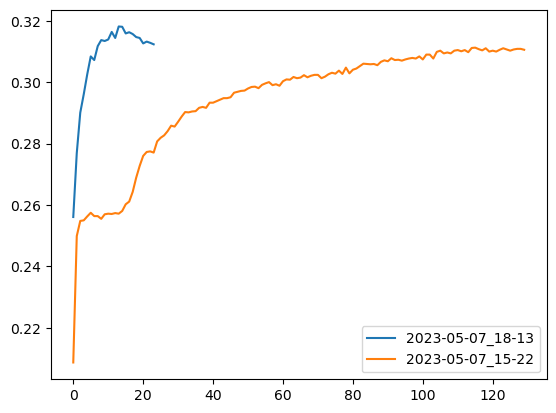

In [42]:
for run in runs:
    sns.lineplot(x=range(len(run_recalls[run])), y=run_recalls[run], label=run)

## Testing

In [43]:
os.makedirs(f'preds', exist_ok=True)

In [44]:
test_dataset = RepeatNetDataset(os.path.join(final_data_dir, 'test.csv'))
test_batch_size = 50
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=test_batch_size, shuffle=False, pin_memory=True)

best_run = '2023-05-07_18-13'
best_epoch = 13

model.load_state_dict(torch.load(f'models/{best_run}/repeatnet_{best_epoch}.pth'))
preds = predict(test_loader, model, device, best_epoch)
save_preds(preds, f'preds/repeatnet_{best_run}_ep{best_epoch}.txt')

data size:  10150


metric       mrr      ndcg    recall
k                                   
1       0.295764  0.295764  0.295764
5       0.382169  0.419897  0.534089
10      0.398358  0.459121  0.655369
20      0.407424  0.492266  0.786700


<Axes: xlabel='k', ylabel='value'>

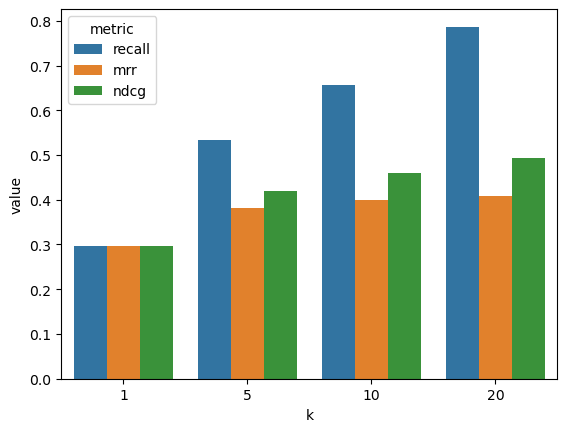

In [45]:
data = {
    'k': [],
    'metric': [],
    'value': [],
}

ns = [1, 5, 10, 20]
recall, mrr, ndcg = evaluate_prediction(f'preds/repeatnet_{best_run}_ep{best_epoch}.txt', ns=ns)
for n in ns:
    data['k'].append(n)
    data['metric'].append('recall')
    data['value'].append(recall[n])
    data['k'].append(n)
    data['metric'].append('mrr')
    data['value'].append(mrr[n])
    data['k'].append(n)
    data['metric'].append('ndcg')
    data['value'].append(ndcg[n])

df = pd.DataFrame(data)
print(df.pivot(index='k', columns='metric', values='value'))
sns.barplot(x='k', y='value', hue='metric', data=df)